# Imports

In [ ]:
import sys
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2

from src.beam import Beam
from src.error_analysis import NumericalErrorAnalysis

# Beam Parameters

In [3]:
# -------------------------
# Realistic parameter set (SI)
# -------------------------
L = 1.5                      # m
rho = 2700.0                 # kg/m^3 (aluminum)
E = 70e9                     # Pa
b = 0.05                     # m (beam width)
h = 0.01                     # m (beam thickness)
A = b*h                      # m^2
I = b*h**3/12                # m^4
rhoA = rho*A                 # kg/m
EI = E*I                     # N*m^2

cd = 2.0                     # N*s/m^2 (moderate damping baseline)
alpha = 0.005                # m (5 mm initial tip-ish amplitude scale)
m = 401                      # grid points (fine enough for D4)

# 1. Uniform step load

In [4]:
# -------------------------
# Case 1: uniform step load
# -------------------------
# q(x,t) is distributed load per length [N/m]
# Example: 20 N/m turns on at t=0.05 s
prob = Beam(
    L=L, m=m,
    rhoA=rhoA, EI=EI, cd=cd,
    alpha=alpha,
    forcing_type="step",
    forcing_params={"q0": 20.0, "t0": 0.05},
)

## 1.1 Temporal Convergence

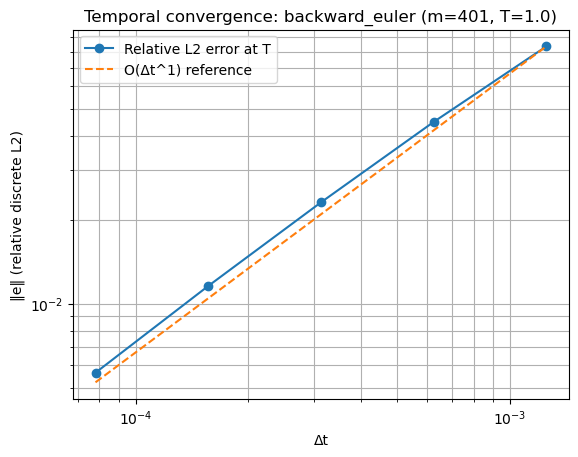


Temporal convergence (backward_euler):
  dt_ref = 4.883e-06
  p between dt=7.813e-05 and 1.563e-04 : 1.033
  p between dt=1.563e-04 and 3.125e-04 : 0.996
  p between dt=3.125e-04 and 6.250e-04 : 0.958
  p between dt=6.250e-04 and 1.250e-03 : 0.900


In [ ]:
nea = NumericalErrorAnalysis(prob)   # or gust

# 1) Temporal convergence for both methods (match expected orders)
res_be = nea.run_temporal_convergence_suite(
    Tfinal=1.0,
    dt_list=[1.25e-3, 6.25e-4, 3.125e-4, 1.5625e-4, 7.8125e-5],
    dt_ref_factor=16
)


## 1.2 Spatial Convergence

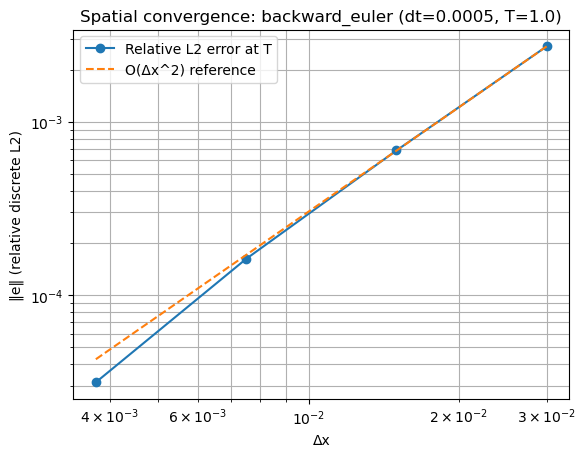


Spatial convergence (backward_euler):
  m_ref = 802, dt_fixed = 5.000e-04
  p between dx=3.750e-03 and 7.500e-03 : 2.367
  p between dx=7.500e-03 and 1.500e-02 : 2.079
  p between dx=1.500e-02 and 3.000e-02 : 1.997


In [ ]:
# 2) Spatial convergence (optional but recommended)
res_dx_trap = nea.spatial_convergence(
    method="backward_euler",
    m_list=[51, 101, 201, 401],
    dt_fixed=5e-4,   # small enough to make time error negligible
    Tfinal=1.0,
    expected_order=2
)

# 2. Localized tip gust

In [ ]:
# -------------------------
# Case 2: localized tip gust (Gaussian pulse)
# -------------------------
# Tip region length dx_tip = 0.05 L (small region near free end)
# Choose a pulse so that total peak force is ~10 N.
# If q_amp is the peak N/m applied over dx_tip, peak total force is approx q_amp * dx_tip.
dx_tip = 0.05 * L            # m
target_peak_force = 10.0     # N
q_amp = target_peak_force / dx_tip  # N/m

gust = Beam(
    L=L, m=m,
    rhoA=rhoA, EI=EI, cd=cd,
    alpha=alpha,
    forcing_type="tip",
    forcing_params={
        "dx_tip": dx_tip,
        "pulse": "gaussian",
        "q_amp": q_amp,       # N/m (chosen so peak total force ~10 N)
        "t_center": 0.20,     # s
        "sigma": 0.02         # s (short-duration gust)
    },
)

## 2.2 Temporal Convergence

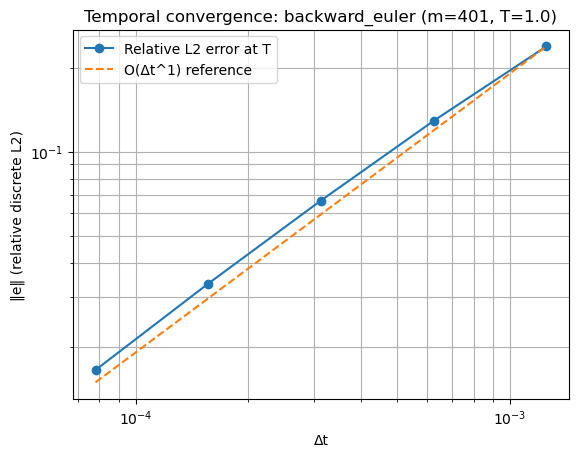


Temporal convergence (backward_euler):
  dt_ref = 4.883e-06
  p between dt=7.813e-05 and 1.563e-04 : 1.028
  p between dt=1.563e-04 and 3.125e-04 : 0.989
  p between dt=3.125e-04 and 6.250e-04 : 0.949
  p between dt=6.250e-04 and 1.250e-03 : 0.887


In [ ]:
nea = NumericalErrorAnalysis(gust)   # or gust

# 1) Temporal convergence for both methods (match expected orders)
res_be = nea.run_temporal_convergence_suite(
    Tfinal=1.0,
    dt_list=[1.25e-3, 6.25e-4, 3.125e-4, 1.5625e-4, 7.8125e-5],
    dt_ref_factor=16
)

## 2.2 Spatial Convergence

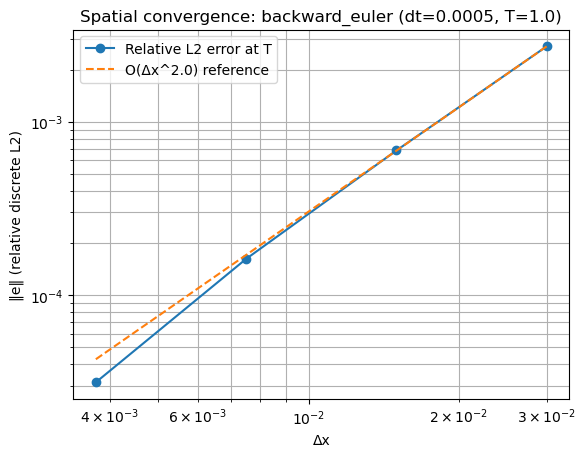


Spatial convergence (backward_euler):
  m_ref = 802, dt_fixed = 5.000e-04
  p between dx=3.750e-03 and 7.500e-03 : 2.367
  p between dx=7.500e-03 and 1.500e-02 : 2.079
  p between dx=1.500e-02 and 3.000e-02 : 1.997


In [ ]:
# 2) Spatial convergence (optional but recommended)
res_dx_trap = nea.spatial_convergence(
    method="backward_euler",
    m_list=[51, 101, 201, 401],
    dt_fixed=5e-4,   # small enough to make time error negligible
    Tfinal=1.0,
    expected_order=2.0
)